In [19]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score,roc_curve, auc
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt


In [2]:
train_df=pd.read_csv("data/train.csv")
test_df=pd.read_csv("data/test.csv")
test_label_df=pd.read_csv("data/test_label.csv")

In [3]:
# -------------------------------
# Setup: Load and scale data
# -------------------------------
feature_cols = [col for col in train_df.columns if col.startswith("feature_")]

X_train = train_df[feature_cols].dropna()
X_test = test_df[feature_cols].dropna()
y_true = test_label_df['label'].values


In [7]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

results = {}


In [9]:
# -------------------------------
# 1. Isolation Forest
# -------------------------------
iso_model = IsolationForest(n_estimators=100, contamination=0.1, random_state=42)
iso_model.fit(X_train_scaled)
iso_preds = iso_model.predict(X_test_scaled)
iso_preds = (iso_preds == -1).astype(int)

results['Isolation Forest'] = {
    "AUC": roc_auc_score(y_true, iso_model.decision_function(X_test_scaled)),
    "Report": classification_report(y_true, iso_preds, output_dict=True)
}

In [10]:
# -------------------------------
# 2. One-Class SVM
# -------------------------------
svm_model = OneClassSVM(kernel="rbf", gamma=0.001, nu=0.1)
svm_model.fit(X_train_scaled)
svm_preds = svm_model.predict(X_test_scaled)
svm_preds = (svm_preds == -1).astype(int)

results['One-Class SVM'] = {
    "AUC": roc_auc_score(y_true, svm_model.decision_function(X_test_scaled)),
    "Report": classification_report(y_true, svm_preds, output_dict=True)
}

In [11]:
# -------------------------------
# 3. Autoencoder
# -------------------------------
input_dim = X_train_scaled.shape[1]
input_layer = Input(shape=(input_dim,))
encoded = Dense(16, activation='relu')(input_layer)
encoded = Dense(8, activation='relu')(encoded)
decoded = Dense(16, activation='relu')(encoded)
decoded = Dense(input_dim, activation='sigmoid')(decoded)

autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

autoencoder.fit(X_train_scaled, X_train_scaled, epochs=10, batch_size=64, shuffle=True, validation_split=0.1, verbose=0)

X_test_recon = autoencoder.predict(X_test_scaled)
reconstruction_error = np.mean(np.power(X_test_scaled - X_test_recon, 2), axis=1)
threshold = np.percentile(reconstruction_error, 95)
ae_preds = (reconstruction_error > threshold).astype(int)

results['Autoencoder'] = {
    "AUC": roc_auc_score(y_true, reconstruction_error),
    "Report": classification_report(y_true, ae_preds, output_dict=True)
}

2746/2746 ━━━━━━━━━━━━━━━━━━━━ 2s 623us/step


In [13]:
# -------------------------------
# Summary Output
# -------------------------------
for model, metrics in results.items():
    print(f"\n🔍 Model: {model}")
    print(f"AUC Score: {metrics['AUC']:.4f}")
    print("Classification Report:")
    report = metrics['Report']
    for label, scores in report.items():
        if isinstance(scores, dict):
            print(f"  {label} - precision: {scores['precision']:.2f}, recall: {scores['recall']:.2f}, f1-score: {scores['f1-score']:.2f}")



🔍 Model: Isolation Forest
AUC Score: 0.2892
Classification Report:
  0 - precision: 0.76, recall: 0.93, f1-score: 0.84
  1 - precision: 0.58, recall: 0.24, f1-score: 0.34
  macro avg - precision: 0.67, recall: 0.58, f1-score: 0.59
  weighted avg - precision: 0.71, recall: 0.74, f1-score: 0.70

🔍 Model: One-Class SVM
AUC Score: 0.3843
Classification Report:
  0 - precision: 0.77, recall: 0.73, f1-score: 0.75
  1 - precision: 0.39, recall: 0.43, f1-score: 0.41
  macro avg - precision: 0.58, recall: 0.58, f1-score: 0.58
  weighted avg - precision: 0.66, recall: 0.65, f1-score: 0.66

🔍 Model: Autoencoder
AUC Score: 0.6471
Classification Report:
  0 - precision: 0.74, recall: 0.98, f1-score: 0.85
  1 - precision: 0.70, recall: 0.13, f1-score: 0.21
  macro avg - precision: 0.72, recall: 0.55, f1-score: 0.53
  weighted avg - precision: 0.73, recall: 0.74, f1-score: 0.67


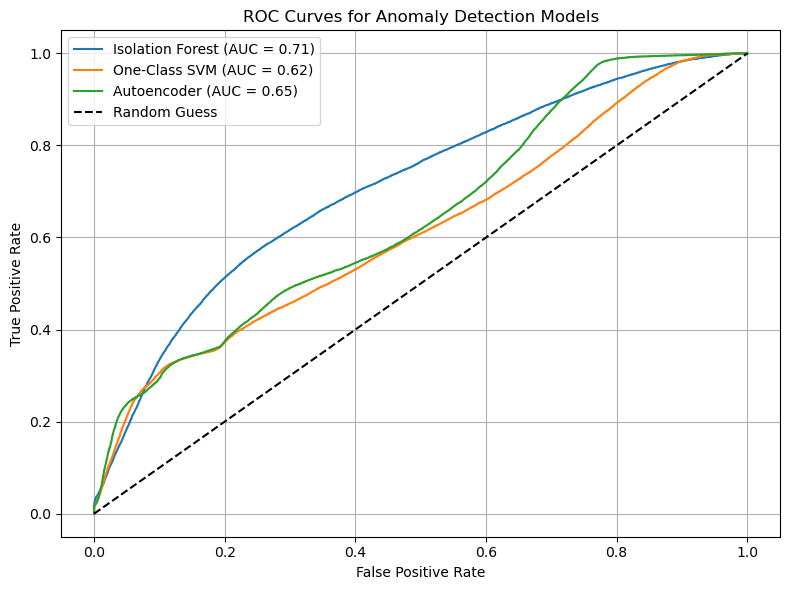

In [21]:
# Scores: higher = more normal → invert for anomaly score
iso_scores = -iso_model.decision_function(X_test_scaled)
svm_scores = -svm_model.decision_function(X_test_scaled)
ae_scores = reconstruction_error  # Already an error (higher = more anomalous)

# ROC curves
fpr_iso, tpr_iso, _ = roc_curve(y_true, iso_scores)
fpr_svm, tpr_svm, _ = roc_curve(y_true, svm_scores)
fpr_ae, tpr_ae, _ = roc_curve(y_true, ae_scores)

auc_iso = auc(fpr_iso, tpr_iso)
auc_svm = auc(fpr_svm, tpr_svm)
auc_ae = auc(fpr_ae, tpr_ae)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr_iso, tpr_iso, label=f'Isolation Forest (AUC = {auc_iso:.2f})')
plt.plot(fpr_svm, tpr_svm, label=f'One-Class SVM (AUC = {auc_svm:.2f})')
plt.plot(fpr_ae, tpr_ae, label=f'Autoencoder (AUC = {auc_ae:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Anomaly Detection Models')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
